In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import math

In [10]:
face_cascade = cv2.CascadeClassifier('/tf/Quan/fer/haarcascade_frontalface_default.xml')

def detect_face(img):
    
    img = np.array(img) # unit8
    img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    img = img.astype(np.uint8)
    
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    
    if len(faces) == 0:
        return img
    
    else:
#         print(faces)
        x,y,w,h = faces[0]
        roi = img[y:y+h, x:x+w]
#         roi = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        
        return roi

In [11]:
def clahe(x):
#     x = np.array(x) # unit8
#     x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
#     x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

In [19]:
from skimage.feature import local_binary_pattern

def lbp_transform(x):
    radius = 2
    n_points = 8 * radius
    METHOD = 'uniform'

    x = local_binary_pattern(x, n_points, radius, method=METHOD)
    
    return x.astype(np.uint8)

In [20]:
import torch
from torchvision import transforms, datasets

train_data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=45),
        transforms.Grayscale(num_output_channels=1),
        transforms.Lambda(detect_face),
        transforms.Lambda(clahe),
        transforms.ToPILImage(),
        transforms.Resize((48,48)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

test_data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Lambda(detect_face),
        transforms.Lambda(clahe),
        transforms.Lambda(lbp_transform),
        transforms.ToPILImage(),
        transforms.Resize((48,48)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

train_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/train', transform=train_data_transform)
val_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/val', transform=test_data_transform)
test_fer = datasets.ImageFolder(root='/tf/data/Quan/fer2013/data/test', transform=test_data_transform)

batch_size =128
train_loader = torch.utils.data.DataLoader(train_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_fer,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)

In [17]:
images, _ = next(iter(train_loader))
images.size()
# images = images.numpy()

torch.Size([128, 1, 48, 48])

tensor(-0.9294) tensor(1.) tensor(0.1428)


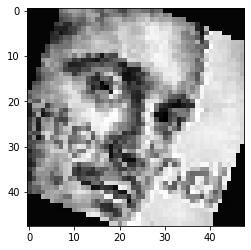

In [48]:
img = images[0]
print(img.min(), img.max(), img.mean())
plt.imshow(img[0,:,:], cmap='gray')

In [23]:
images, labels = next(iter(test_loader))
images.size(), labels.size()
# images = images.numpy()

(torch.Size([128, 1, 48, 48]), torch.Size([128]))

tensor(-1.) tensor(-0.8667) tensor(-0.9207)
tensor(6)


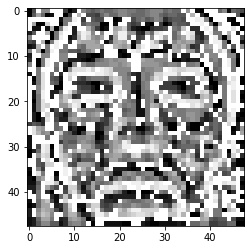

In [24]:
index = 2
img = images[index]
lb = labels[index]
print(img.min(), img.max(), img.mean())
print(lb)
plt.imshow(img[0,:,:], cmap='gray')

In [41]:
face_cascade = cv2.CascadeClassifier('/tf/Quan/fer/haarcascade_frontalface_default.xml')

# norm_image = cv2.normalize(img[0,:,:].numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
norm_image = img[0,:,:].numpy().astype(np.uint8)


faces = face_cascade.detectMultiScale(norm_image, 1.3, 4)
# Draw rectangle around the faces

print(len(faces))
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

0


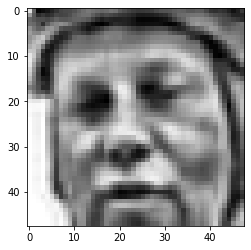

In [42]:
plt.imshow(img[0,:,:], cmap='gray')

In [157]:
norm_image.shape

(48, 48)

## Training (SVGG3_2)

In [6]:
class SVblock(nn.Module):
    def __init__(self, in_neurons, nb_neurons, kernel_size=(3,3), batch_norm=True, activation='relu', **kwargs):
        '''
    in_neurons: C_in
    nb_neurons: n_filters of conv2d
    '''
        super(SVblock, self).__init__()

        self.index = kwargs['index'] if 'index' in kwargs else None
        self.conv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        self.conv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=kernel_size, padding=1, stride=1)
        
        self.bn1 = nn.BatchNorm2d(nb_neurons)
        self.bn2 = nn.BatchNorm2d(nb_neurons)
        self.bn3 = nn.BatchNorm2d(nb_neurons)
        
        self.preconv1 = nn.Conv2d(in_neurons, nb_neurons, kernel_size=1)
        self.preconv2 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.preconv3 = nn.Conv2d(nb_neurons, nb_neurons, kernel_size=1)
        self.bn1_ = nn.BatchNorm2d(nb_neurons)
        self.bn2_ = nn.BatchNorm2d(nb_neurons)
        self.bn3_ = nn.BatchNorm2d(nb_neurons)
        
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
     


    def forward(self, x):        
        
        x0_res = self.preconv1(x)
        x0_res = self.bn1_(x0_res)
        
        # 1st
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = x1 + x0_res
        x1 = self.relu(x1)
        
        x1_res = self.preconv2(x1)
        x1_res = self.bn2_(x1_res)

        # 2nd
        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = x2 + x1_res
        x2 = self.relu(x2)
        
        x2_res = self.preconv3(x2)
        x2_res = self.bn3_(x2_res)
        
        # 3rd
        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = x3 + x2_res
        x3 = self.relu(x3)

        # maxpooling
        x_out = self.maxpool(x3)

        return x_out

In [7]:
class Attention(nn.Module):
    
    def __init__(self, feature_depth, **kwargs):
        super(Attention, self).__init__()
        
        self.iconv_out = nn.Conv2d(feature_depth, feature_depth, kernel_size=1)
        self.bn_out = nn.BatchNorm2d(feature_depth)
        
        # ensure the init stage is the indentical mapping
#         nn.init.zeros_(self.iconv_out.weight)
#         nn.init.zeros_(self.iconv_out.bias)
#         nn.init.zeros_(self.bn_out.weight)
#         nn.init.zeros_(self.bn_out.bias)
        
    def forward(self, x):

        _x1 = nn.Flatten(-2)(x)
        _x2 = nn.Flatten(-2)(x)
            
        QK = torch.matmul(_x1, _x2.permute(0,2,1))
        QK = QK / (_x1.size(1) * _x1.size(2))
        QK = (QK + QK.permute(0,2,1)).sum(1)
        QK = QK.sigmoid()
        QK = QK.unsqueeze(-1).unsqueeze(-1)
        
        
        x_out = (1 + QK) * x
        
        identity_x = self.iconv_out(x)
        identity_x = self.bn_out(x)

        x_out = x_out + identity_x
        
        x_out = nn.ReLU()(x_out)
        
        return x_out

In [8]:
class SVGG(nn.Module):
    
    def __init__(self, **kwargs):
        super(SVGG, self).__init__()

        self.device = torch.device('cpu') if not 'device' in kwargs else kwargs['device']

        self.sv0 = SVblock(1, 64).to(self.device)
        self.sv1 = SVblock(64, 128).to(self.device)
        self.sv2 = SVblock(128, 256).to(self.device)
        self.sv3 = SVblock(256, 512).to(self.device)
        self.sv4 = SVblock(512, 1024).to(self.device)

        self.wf0 = Attention(64,).to(self.device)
        self.wf1 = Attention(128).to(self.device)
        self.wf2 = Attention(256).to(self.device)
        self.wf3 = Attention(512).to(self.device)
        self.wf4 = Attention(1024).to(self.device)

        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 7)
        self.bn2 = nn.BatchNorm1d(7)
        
    
    def forward(self, x):
        x0 = self.sv0(x)
        x_wf0 = self.wf0(x0)

        x1 = self.sv1(x_wf0)
        x_wf1 = self.wf1(x1)

        x2 = self.sv2(x_wf1)
        x_wf2 = self.wf2(x2)

        x3 = self.sv3(x_wf2)
        x_wf3 = self.wf3(x3)
        
        x4 = self.sv4(x_wf3)
        x_wf4 = self.wf4(x4)

        x_wf4 = nn.AvgPool2d(kernel_size=(x_wf4.size(-2), x_wf4.size(-1)))(x_wf4)
    
        x = nn.Flatten()(x_wf4)

        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = self.bn2(x)

        return x

In [9]:
from torch.optim import lr_scheduler

device = torch.device('cuda')
print(device)

model = SVGG(device=device)

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
# reduce_factor = 2
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [10]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/'
model_name = 'svgg3_2_preprocess'
model_path = os.path.join(model_folder, model_name + '.pt')

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  1
- Avg.loss: 1.811  | Avg.acc: 0.274
- Avg. val_loss: 1.584  | Avg. val_acc: 0.385
* Update optimal model
Epoch:  2


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SVblock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


- Avg.loss: 1.502  | Avg.acc: 0.419
- Avg. val_loss: 1.442  | Avg. val_acc: 0.462
* Update optimal model
Epoch:  3
- Avg.loss: 1.380  | Avg.acc: 0.470
- Avg. val_loss: 1.377  | Avg. val_acc: 0.476
* Update optimal model
Epoch:  4
- Avg.loss: 1.328  | Avg.acc: 0.491
- Avg. val_loss: 1.414  | Avg. val_acc: 0.467
Epoch:  5
- Avg.loss: 1.302  | Avg.acc: 0.500
- Avg. val_loss: 1.479  | Avg. val_acc: 0.444
Epoch:  6
- Avg.loss: 1.277  | Avg.acc: 0.509
- Avg. val_loss: 1.348  | Avg. val_acc: 0.482
* Update optimal model
Epoch:  7
- Avg.loss: 1.260  | Avg.acc: 0.520
- Avg. val_loss: 1.341  | Avg. val_acc: 0.476
Epoch:  8
- Avg.loss: 1.252  | Avg.acc: 0.523
- Avg. val_loss: 1.270  | Avg. val_acc: 0.509
* Update optimal model
Epoch:  9
- Avg.loss: 1.233  | Avg.acc: 0.529
- Avg. val_loss: 1.229  | Avg. val_acc: 0.535
* Update optimal model
Epoch:  10
- Avg.loss: 1.223  | Avg.acc: 0.536
- Avg. val_loss: 1.201  | Avg. val_acc: 0.548
* Update optimal model
Epoch:  11
- Avg.loss: 1.209  | Avg.acc: 0.

- Avg. val_loss: 0.970  | Avg. val_acc: 0.632
Epoch:  85
- Avg.loss: 0.884  | Avg.acc: 0.666
- Avg. val_loss: 0.977  | Avg. val_acc: 0.634
Epoch:  86
- Avg.loss: 0.884  | Avg.acc: 0.668
- Avg. val_loss: 0.990  | Avg. val_acc: 0.630
Epoch    86: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  87
- Avg.loss: 0.866  | Avg.acc: 0.675
- Avg. val_loss: 0.945  | Avg. val_acc: 0.651
* Update optimal model
Epoch:  88
- Avg.loss: 0.852  | Avg.acc: 0.677
- Avg. val_loss: 0.947  | Avg. val_acc: 0.649
Epoch:  89
- Avg.loss: 0.849  | Avg.acc: 0.683
- Avg. val_loss: 0.961  | Avg. val_acc: 0.639
Epoch:  90
- Avg.loss: 0.851  | Avg.acc: 0.680
- Avg. val_loss: 0.945  | Avg. val_acc: 0.645
Epoch:  91
- Avg.loss: 0.847  | Avg.acc: 0.682
- Avg. val_loss: 0.973  | Avg. val_acc: 0.626
Epoch:  92
- Avg.loss: 0.849  | Avg.acc: 0.679
- Avg. val_loss: 0.973  | Avg. val_acc: 0.648
Epoch:  93
- Avg.loss: 0.840  | Avg.acc: 0.685
- Avg. val_loss: 0.984  | Avg. val_acc: 0.639
Epoch:  94
- Avg.loss: 0.842  | 

In [11]:
model = model.to(device)

model_folder = '/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/'
model_name = 'svgg3_2_preprocess'
model_path = os.path.join(model_folder, model_name + '.pt')

# best_acc = 0.0
# curloss = 0.0
# hist = []

for epoch in range(100, 150):

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0

    # TRAIN
    model.train()
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += acc
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / (i+1), running_acc / (i+1)))
    avgloss = running_loss / (i+1)
    avgacc = running_acc / (i+1)
    
    # print gradient flow figure
#     plot_grad_flow(model.named_parameters(), epoch, avgloss, avgacc,
#                    savepath=os.path.join(model_folder, model_name + '_gf' + '_' + str(epoch) + '.png'))

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += loss.item()
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

    avgvalloss = running_valloss / (i+1)
    avgvalcc = running_valacc / (i+1)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / (i+1)):
        best_acc = (running_valacc / (i+1))
        curloss = (running_valloss / (i+1))
        torch.save(model, model_path)
        print('* Update optimal model')
        
    scheduler.step(avgvalloss)

print('Finished Training')

Epoch:  101
- Avg.loss: 0.826  | Avg.acc: 0.692
- Avg. val_loss: 0.971  | Avg. val_acc: 0.644
Epoch:  102
- Avg.loss: 0.827  | Avg.acc: 0.691
- Avg. val_loss: 0.977  | Avg. val_acc: 0.639
Epoch:  103
- Avg.loss: 0.825  | Avg.acc: 0.690
- Avg. val_loss: 0.966  | Avg. val_acc: 0.646
Epoch:  104
- Avg.loss: 0.830  | Avg.acc: 0.688
- Avg. val_loss: 0.973  | Avg. val_acc: 0.648
Epoch:  105
- Avg.loss: 0.824  | Avg.acc: 0.691
- Avg. val_loss: 0.970  | Avg. val_acc: 0.637
Epoch   105: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  106
- Avg.loss: 0.807  | Avg.acc: 0.700
- Avg. val_loss: 0.956  | Avg. val_acc: 0.651
Epoch:  107
- Avg.loss: 0.802  | Avg.acc: 0.698
- Avg. val_loss: 0.933  | Avg. val_acc: 0.660
* Update optimal model
Epoch:  108
- Avg.loss: 0.803  | Avg.acc: 0.699
- Avg. val_loss: 0.977  | Avg. val_acc: 0.650
Epoch:  109
- Avg.loss: 0.802  | Avg.acc: 0.699
- Avg. val_loss: 0.951  | Avg. val_acc: 0.657
Epoch:  110
- Avg.loss: 0.799  | Avg.acc: 0.702
- Avg. val_loss: 0.96

([<matplotlib.lines.Line2D at 0x7f62211ccb70>,
 0.6651400862068966,
 0.9459596420156544)

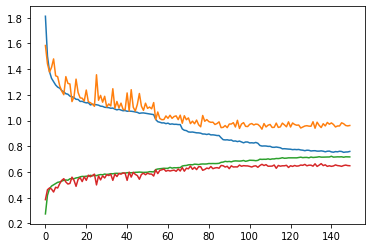

In [12]:
plt.plot(hist), best_acc, curloss

In [35]:
import pickle

pickle.dump(hist, open('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/svgg3_2_preprocess_hist.hdf5', 'wb'))

In [14]:
test_model = torch.load('/tf/data/Quan/fer2013/backtobasics_cleaned_data/attention3/svgg3_2_preprocess.pt')

# EVALUATE
test_model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = test_model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum()/labels.size(0))
    loss = criterion(outputs, labels)

    #         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += loss.item()
    running_valacc += acc

print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / (i+1), running_valacc / (i+1)))

- Avg. val_loss: 0.931  | Avg. val_acc: 0.659


In [27]:
document1 = "apple apple banana a b c d d w"
document2 = "apple apple apple apple banana banana"

documents = (
    document1,
    document2)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
print(X)
(4, 9)

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
  (0, 1)	0.46979138557992045
  (0, 2)	0.5802858236844359
  (0, 6)	0.38408524091481483
  (0, 3)	0.38408524091481483
  (0, 8)	0.38408524091481483
  (1, 5)	0.5386476208856763
  (1, 1)	0.6876235979836938
  (1, 6)	0.281088674033753
  (1, 3)	0.281088674033753
  (1, 8)	0.281088674033753
  (2, 4)	0.511848512707169
  (2, 7)	0.511848512707169
  (2, 0)	0.511848512707169
  (2, 6)	0.267103787642168
  (2, 3)	0.267103787642168
  (2, 8)	0.267103787642168
  (3, 1)	0.46979138557992045
  (3, 2)	0.5802858236844359
  (3, 6)	0.38408524091481483
  (3, 3)	0.38408524091481483
  (3, 8)	0.38408524091481483


(4, 9)

<1x9 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>